#### Prepared for Gabor's Data Analysis

### Data Analysis for Business, Economics, and Policy
by Gabor Bekes and  Gabor Kezdi
 
Cambridge University Press 2021

**[gabors-data-analysis.com ](https://gabors-data-analysis.com/)**

 License: Free to share, modify and use for educational purposes. 
 Not to be used for commercial purposes.

### Chapter 14
**CH14B Predicting AirBnB apartment prices: selecting a regression model**

using the airbnb dataset

version 0.9.0 2025-08-14

In [1]:
import os
import sys
import warnings

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import regex as re
import statsmodels.formula.api as smf

warnings.filterwarnings("ignore")

In [2]:
# Current script folder
current_path = os.getcwd()
dirname = current_path.split("da_case_studies")[0]

# location folders
data_in = dirname + "da_data_repo/airbnb/clean/"
data_out = dirname + "da_case_studies/ch14-airbnb-reg/"
output = dirname + "da_case_studies/ch14-airbnb-reg/output/"
func = dirname + "da_case_studies/ch00-tech-prep/"
sys.path.append(func)

import py_helper_functions as da

sns.set_theme(rc=da.da_theme, palette=da.color)

In [3]:
# Import data
data = pd.read_csv(data_in + "airbnb_london_cleaned_book.csv", index_col=0)
# data = pd.read_csv("https://osf.io/download/7n96w/", index_col=0)



In [4]:
for g in data.columns:
    if "reviews" in g:
        print(g)


number_of_reviews
reviews_per_month


In [5]:
data.property_type.value_counts()


property_type
Apartment             38270
House                 13055
Bed & Breakfast        1066
Townhouse               372
Other                   267
Loft                    254
Dorm                    127
Guesthouse               81
Boat                     69
Serviced apartment       65
Condominium              56
Bungalow                 47
Boutique hotel           35
Hostel                   32
Cabin                    32
Villa                    12
Camper/RV                 9
Chalet                    9
Yurt                      4
Hut                       3
Castle                    3
Tent                      2
Parking Space             2
Ryokan (Japan)            1
Lighthouse                1
Igloo                     1
Cave                      1
Name: count, dtype: int64

In [6]:
# Rename roomt type because it is too long
data = data.loc[data.property_type.isin(["Apartment", "House", "Townhouse"])]


In [7]:
data.property_type = [x if x != "Townhouse" else "House" for x in data.property_type]
data["f_property_type"] = data["property_type"].astype("category")
data["f_room_type"] = data["room_type"].astype("category")
data["f_room_type2"] = (
    data["f_room_type"]
    .replace(
        {
            "Entire home/apt": "Entire/Apt",
            "Private room": "Private",
            "Shared room": "Shared",
        }
    )
    .astype("category")
)


In [8]:
# cancellation policy as factor
data.cancellation_policy.value_counts()


cancellation_policy
strict             21287
flexible           18435
moderate           11959
super_strict_30       15
super_strict_60        1
Name: count, dtype: int64

In [9]:
data["cancellation_policy"] = [
    "strict" if x in ("super_strict_30", "super_strict_60") else x
    for x in data.cancellation_policy
]
data["f_cancellation_policy"] = data["cancellation_policy"].astype("category")


In [10]:
data.bed_type.value_counts()


bed_type
Real Bed         50701
Pull-out Sofa      600
Futon              239
Couch               98
Airbed              59
Name: count, dtype: int64

In [11]:
data["bed_type"] = [
    "Couch" if x in ("Futon", "Pull-out Sofa", "Airbed") else x for x in data.bed_type
]
data["f_bed_type"] = data["bed_type"].astype("category")
data["f_neighbourhood_cleansed"] = data["neighbourhood_cleansed"].astype("category")


In [12]:
## Create Numerical variables
data["usd_price_day"] = data["price"]
data["p_host_response_rate"] = data["host_response_rate"].astype("float")
data = data.rename({"cleaning_fee": "usd_cleaning_fee"}, axis=1)


In [13]:
for column in (
    "accommodates",
    "bathrooms",
    "review_scores_rating",
    "number_of_reviews",
    "guests_included",
    "reviews_per_month",
    "extra_people",
    "minimum_nights",
    "beds",
):
    data["n_" + re.sub(r"[^[:alnum:]_]", "", column.lower())] = data[column].astype(
        "float"
    )


In [14]:
data["n_days_since"] = pd.to_datetime(
    data["calendar_last_scraped"], format="%Y-%m-%d"
) - pd.to_datetime(data["first_review"], format="%Y-%m-%d")
# Previous row creates a timedelta object in each row. Get the elapsed number of days like:
data["n_days_since"] = [x.days for x in data["n_days_since"]]


In [15]:
for col in data.columns[71:121]:
    data["d_" + re.sub(r"[^[:alnum:]_]", "", col.lower())] = data[col].astype(int)


In [16]:
amenities = list(data.filter(regex="^d_.*"))
len(amenities)


50

In [17]:
data.filter(regex=("^d_.*|^n_.*|^f_.*|^p_.*|^usd_.*")).columns


Index(['usd_cleaning_fee', 'f_property_type', 'f_room_type', 'f_room_type2',
       'f_cancellation_policy', 'f_bed_type', 'f_neighbourhood_cleansed',
       'usd_price_day', 'p_host_response_rate', 'n_accommodates',
       'n_bathrooms', 'n_review_scores_rating', 'n_number_of_reviews',
       'n_guests_included', 'n_reviews_per_month', 'n_extra_people',
       'n_minimum_nights', 'n_beds', 'n_days_since', 'd_24hourcheckin',
       'd_airconditioning', 'd_breakfast', 'd_buzzerwirelessintercom',
       'd_cabletv', 'd_carbonmonoxidedetector', 'd_cats', 'd_dogs',
       'd_doorman', 'd_doormanentry', 'd_dryer', 'd_elevatorinbuilding',
       'd_essentials', 'd_familykidfriendly', 'd_fireextinguisher',
       'd_firstaidkit', 'd_freeparkingonpremises', 'd_freeparkingonstreet',
       'd_gym', 'd_hairdryer', 'd_hangers', 'd_heating', 'd_hottub',
       'd_indoorfireplace', 'd_internet', 'd_iron', 'd_keypad', 'd_kitchen',
       'd_laptopfriendlyworkspace', 'd_lockonbedroomdoor', 'd_lockbox

In [18]:
# keep columns if contain d_, n_,f_, p_, usd_ and some others
data = data.filter(regex=("^d_.*|^n_.*|^f_.*|^p_.*|^usd_.*")).join(
    data[
        [
            "price",
            "id",
            "neighbourhood_cleansed",
            "cancellation_policy",
            "room_type",
            "property_type",
        ]
    ]
)


In [19]:
# with price info only
data = data.dropna(subset=["price"])


In [20]:
##################################
# DESCRIBE
data = data.loc[data.neighbourhood_cleansed == "Hackney"]


In [21]:
N = data.shape[0]
N


4499

In [22]:
#####################
### look at price ###
#####################
# data['price']=[x.replace(',','') for x in data['price']]
data["price"] = data["price"].str.replace(",", "").astype("float")


In [23]:
data.price.describe()


count    4499.000000
mean       82.523227
std       119.327855
min        10.000000
25%        40.000000
50%        65.000000
75%       100.000000
max      6890.000000
Name: price, dtype: float64

In [24]:
data["ln_price"] = np.log(data.price)


In [25]:
# Remove extreme values + missing from prices (this case: only 3 missing values)
data = data.loc[data.price < 1000]


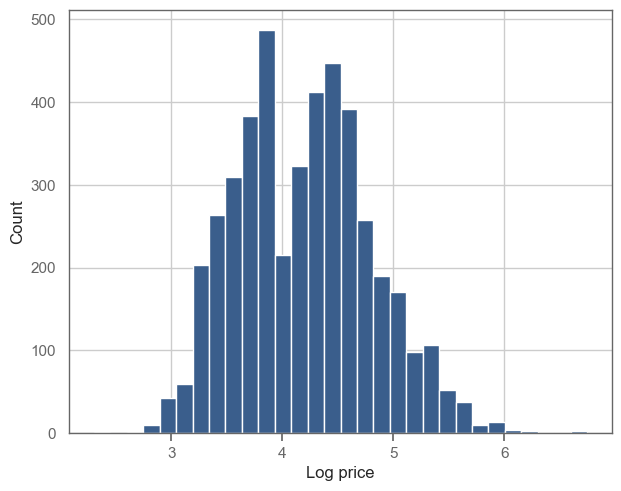

In [26]:
sns.histplot(data, x="ln_price", bins=30, alpha=1)
plt.ylabel("Count")
plt.xlabel("Log price")
plt.show()

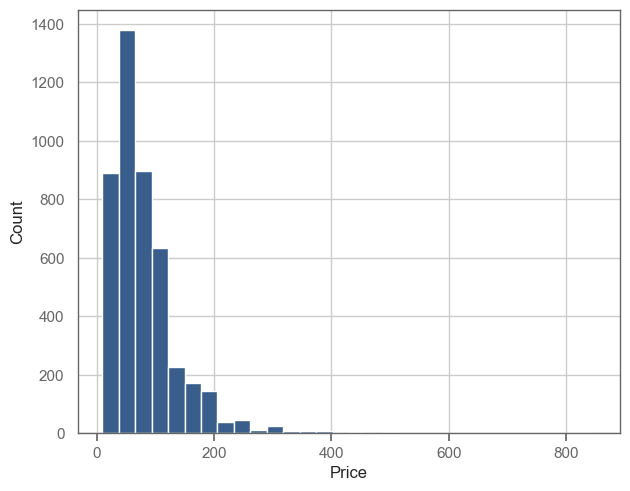

In [27]:
sns.histplot(data, x="price", bins=30, alpha=1)
plt.ylabel("Count")
plt.xlabel("Price")
plt.show()

In [28]:
################################################

# look at some cnts. key vars, functional form #

################################################


In [29]:
data.groupby("n_accommodates").agg(
    mean_price=("price", np.mean),
    min_price=("price", np.min),
    max_price=("price", np.max),
    n=("price", "size"),
)


,mean_price,min_price,max_price,n
n_accommodates,,,,
1.0,40.699065,10.0,850.0,535
2.0,58.558369,11.0,800.0,2330
3.0,87.254826,25.0,280.0,259
4.0,110.173629,20.0,400.0,766
5.0,125.018519,30.0,350.0,162
6.0,155.321799,47.0,400.0,289
7.0,174.903846,49.0,450.0,52
8.0,192.322581,75.0,450.0,62
9.0,197.900000,135.0,250.0,10


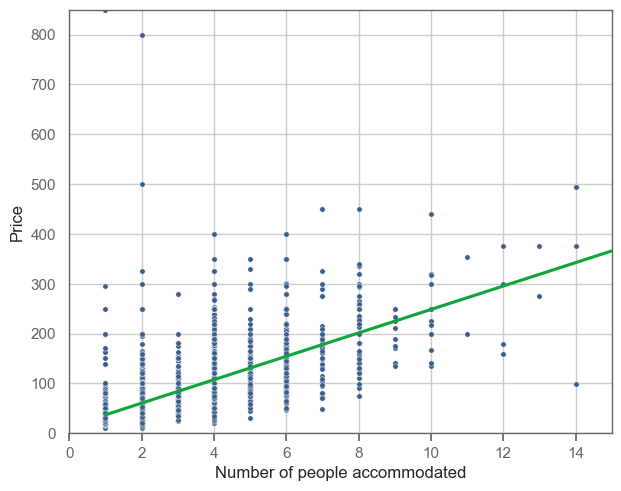

In [30]:
sns.scatterplot(data=data, x="n_accommodates", y="price", s=15)
sns.regplot(
    data=data, x="n_accommodates", y="price", color=da.color[1], scatter=False, ci=None
)
plt.ylim(0, 850)
plt.xlim(0, 15)
plt.xlabel("Number of people accommodated")
plt.ylabel("Price")
plt.show()

In [31]:
data["n_accommodates2"] = data["n_accommodates"] ** 2
data["ln_accommodates"] = np.log(data["n_accommodates"])
data["ln_accommodates2"] = data["ln_accommodates"] ** 2

In [32]:
# Regression 1: ln price and num of accomodates and squares
smf.ols(
    formula="ln_price ~ n_accommodates + n_accommodates2", data=data
).fit().summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               ln_price   R-squared:                       0.514
Model:                            OLS   Adj. R-squared:                  0.514
Method:                 Least Squares   F-statistic:                     2381.
Date:                Sat, 08 Feb 2025   Prob (F-statistic):               0.00
Time:                        16:29:46   Log-Likelihood:                -2550.0
No. Observations:                4496   AIC:                             5106.
Df Residuals:                    4493   BIC:                             5125.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           3.2095      0.020    157.554      0.000       3.170       3.249
n_accommodates      0.4180      0.011     38.828      0.000       0.397       0.439
n_accommodates2    -0.0193      0.001    -16.884      0.000      -0.022      -0.017
==============================================================================
Omnibus:                      285.213   Durbin-Watson:                   1.968
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              586.152
Skew:                           0.433   Prob(JB):                    5.23e-128
Kurtosis:                       4.543   Cond. No.                         71.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [33]:
# Regression 2: ln price and log num of accomodates

smf.ols(formula="ln_price ~ ln_accommodates", data=data).fit().summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               ln_price   R-squared:                       0.511
Model:                            OLS   Adj. R-squared:                  0.511
Method:                 Least Squares   F-statistic:                     4702.
Date:                Sat, 08 Feb 2025   Prob (F-statistic):               0.00
Time:                        16:29:46   Log-Likelihood:                -2564.8
No. Observations:                4496   AIC:                             5134.
Df Residuals:                    4494   BIC:                             5146.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           3.4452      0.013    273.070      0.000       3.420       3.470
ln_accommodates     0.8249      0.012     68.568      0.000       0.801       0.848
==============================================================================
Omnibus:                      289.763   Durbin-Watson:                   1.952
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              684.731
Skew:                           0.396   Prob(JB):                    2.05e-149
Kurtosis:                       4.740   Cond. No.                         3.68
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [34]:
# Regression 3: ln price and num of accomodates
smf.ols(formula="ln_price ~ n_accommodates", data=data).fit().summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               ln_price   R-squared:                       0.484
Model:                            OLS   Adj. R-squared:                  0.484
Method:                 Least Squares   F-statistic:                     4210.
Date:                Sat, 08 Feb 2025   Prob (F-statistic):               0.00
Time:                        16:29:46   Log-Likelihood:                -2688.3
No. Observations:                4496   AIC:                             5381.
Df Residuals:                    4494   BIC:                             5393.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          3.4830      0.013    273.420      0.000       3.458       3.508
n_accommodates     0.2473      0.004     64.884      0.000       0.240       0.255
==============================================================================
Omnibus:                      182.797   Durbin-Watson:                   1.967
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              343.122
Skew:                           0.310   Prob(JB):                     3.10e-75
Kurtosis:                       4.203   Cond. No.                         6.92
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [35]:
data.groupby("n_beds").agg(
    mean_price=("price", np.mean),
    min_price=("price", np.min),
    max_price=("price", np.max),
    n=("price", "size"),
)


,mean_price,min_price,max_price,n
n_beds,,,,
1.0,57.315807,10.0,850.0,2948
2.0,107.765273,24.0,400.0,933
3.0,141.196429,18.0,450.0,336
4.0,149.888889,30.0,400.0,171
5.0,176.980769,20.0,440.0,52
6.0,187.379310,90.0,450.0,29
7.0,283.714286,98.0,495.0,7
8.0,258.333333,200.0,300.0,3
9.0,375.000000,375.0,375.0,1


In [36]:
# maybe best is to have log beds
data["ln_beds"] = np.log(data["n_beds"])


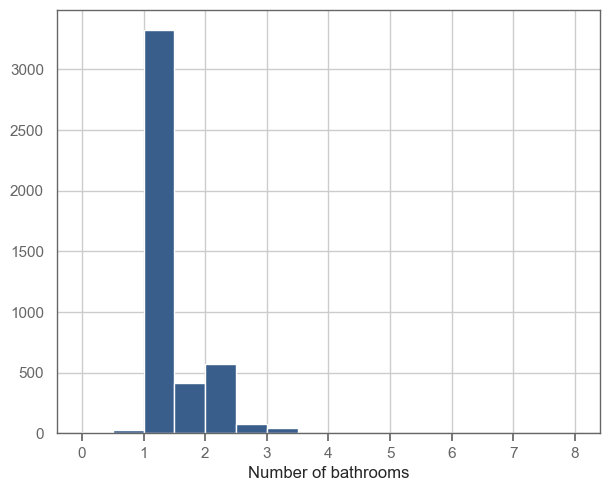

In [37]:
sns.histplot(data, x="n_bathrooms", binwidth=0.5, alpha=1)
plt.ylabel(None)
plt.xlabel("Number of bathrooms")
plt.show()

In [38]:
bins = [0, 1, 2, 10]
labels = [0, 1, 2]

data['f_bathroom'] = pd.cut(data['n_bathrooms'], bins=bins, labels=labels, right=False)

In [39]:
data["n_bathrooms"].dtype

dtype('float64')

In [40]:
data.groupby("f_bathroom").agg(mean_price=("price", np.mean), n=("price", "size"))

,mean_price,n
f_bathroom,,
0,49.055556,36
1,73.113102,3740
2,121.389592,711


In [41]:
## Number of reviews
nreview_plot = data.loc[data.n_number_of_reviews < 100]


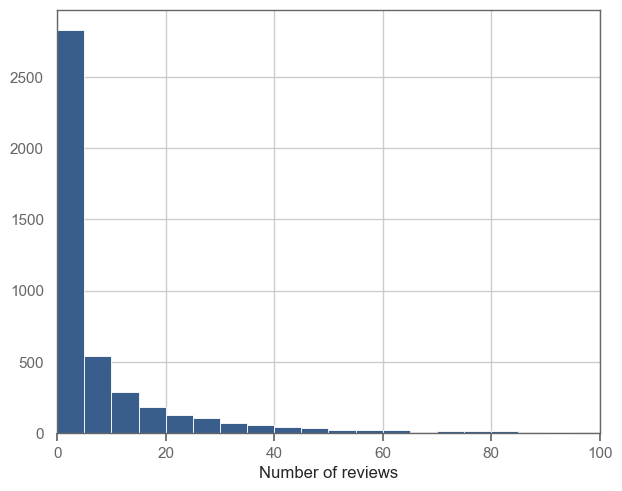

In [42]:
sns.histplot(data, x="n_number_of_reviews", binwidth=5, alpha=1)
plt.ylabel(None)
plt.xlabel("Number of reviews")
plt.xlim(0, 100)
plt.show()

In [43]:
# number of reviews: use logs as well
data["ln_number_of_reviews"] = np.log(data["n_number_of_reviews"] + 1)


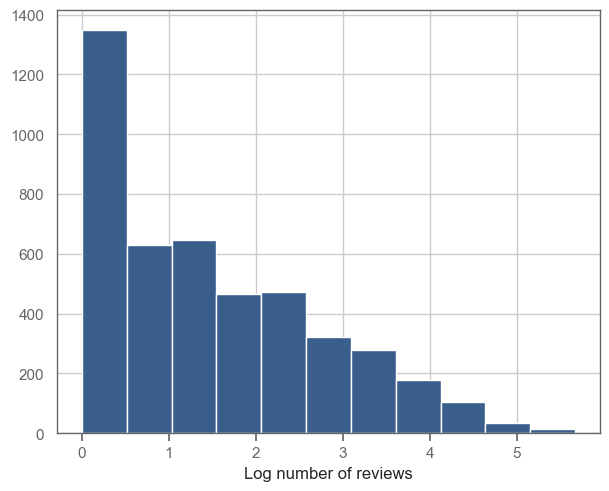

In [44]:
sns.histplot(data, x="ln_number_of_reviews", binwidth=0.5, alpha=1)
plt.ylabel(None)
plt.xlabel("Log number of reviews")
plt.show()

In [45]:
bins = [0,1,51,max(data.n_number_of_reviews)]
labels = [0,1,2]
data["f_number_of_reviews"] = pd.cut(data["n_number_of_reviews"],bins = bins, labels = labels, right = False)

In [46]:
data.groupby("f_number_of_reviews").agg(
    median_price=("price", np.median),
    mean_price=("price", np.mean),
    n=("price", "size"),
)


,median_price,mean_price,n
f_number_of_reviews,,,
0,60.0,80.883617,1349
1,69.0,79.593952,2943
2,75.0,92.522167,203


In [47]:
# Regression 1: log-price and number of reviews
smf.ols(formula="ln_price ~ f_number_of_reviews", data=data).fit().summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               ln_price   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     6.070
Date:                Sat, 08 Feb 2025   Prob (F-statistic):            0.00233
Time:                        16:29:47   Log-Likelihood:                -4167.6
No. Observations:                4495   AIC:                             8341.
Df Residuals:                    4492   BIC:                             8360.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    4.1695      0.017    250.334      0.000       4.137       4.202
f_number_of_reviews[T.1]     0.0224      0.020      1.114      0.265      -0.017       0.062
f_number_of_reviews[T.2]     0.1604      0.046      3.483      0.000       0.070       0.251
==============================================================================
Omnibus:                       83.309   Durbin-Watson:                   1.979
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               82.793
Skew:                           0.308   Prob(JB):                     1.05e-18
Kurtosis:                       2.748   Cond. No.                         6.33
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [48]:
# Regression 2: log-price and log number of reviews
smf.ols(formula="ln_price ~ ln_number_of_reviews", data=data).fit().summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               ln_price   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     31.08
Date:                Sat, 08 Feb 2025   Prob (F-statistic):           2.62e-08
Time:                        16:29:47   Log-Likelihood:                -4158.8
No. Observations:                4496   AIC:                             8322.
Df Residuals:                    4494   BIC:                             8334.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                4.1369      0.013    309.822      0.000       4.111       4.163
ln_number_of_reviews     0.0385      0.007      5.575      0.000       0.025       0.052
==============================================================================
Omnibus:                       87.003   Durbin-Watson:                   1.979
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               87.233
Skew:                           0.318   Prob(JB):                     1.14e-19
Kurtosis:                       2.755   Cond. No.                         3.29
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [49]:
## Time since
# Create variables, measuring the time since: squared, cubic, logs
for var in [
    "ln_days_since",
    "ln_days_since2",
    "ln_days_since3",
    "n_days_since2",
    "n_days_since3",
]:
    if var[:2] == "ln":
        try:
            data[var] = np.log(data["n_days_since"]) ** int(var[-1])
        except ValueError:
            data[var] = np.log(data["n_days_since"])
    else:
        data[var] = (data["n_days_since"]) ** int(var[-1])


In [50]:
# Check the effect
lndays_plot = data.loc[(data.price <= 800) & (data.ln_days_since > 2)]


In [51]:
data.n_number_of_reviews.describe()


count    4496.000000
mean       10.141904
std        22.342473
min         0.000000
25%         0.000000
50%         2.000000
75%        10.000000
max       290.000000
Name: n_number_of_reviews, dtype: float64

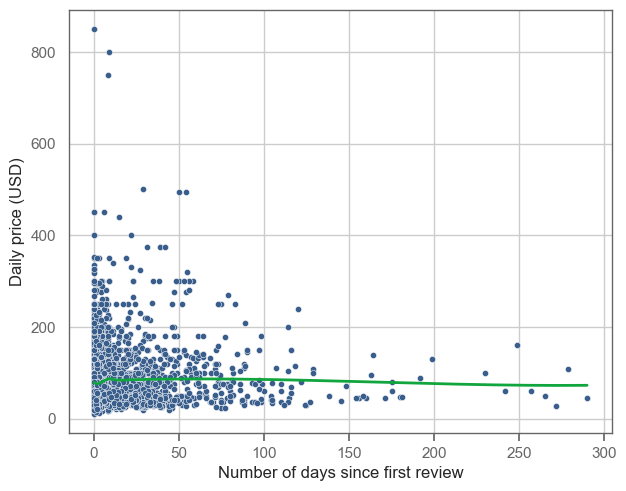

In [52]:
sns.scatterplot(data=data, x="n_number_of_reviews", y="price", s=20)
da.plot_loess(data, "n_number_of_reviews", "price", span=0.8)
plt.xlabel("Number of days since first review")
plt.ylabel("Daily price (USD)")
plt.show()

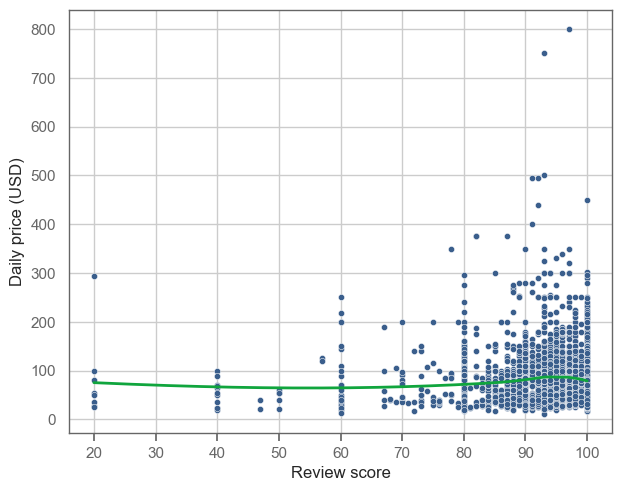

In [53]:
sns.scatterplot(data=data, x="n_review_scores_rating", y="price", s=20)
da.plot_loess(data, "n_review_scores_rating", "price", span=0.8)
plt.xlabel("Review score")
plt.ylabel("Daily price (USD)")
plt.show()

In [54]:
data["ln_review_scores_rating"] = np.log(data["n_review_scores_rating"])


In [55]:
# Regression 1) ln price - num of review scores
smf.ols(formula="ln_price ~ n_review_scores_rating", data=data).fit().summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               ln_price   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     20.92
Date:                Sat, 08 Feb 2025   Prob (F-statistic):           4.97e-06
Time:                        16:29:47   Log-Likelihood:                -2763.3
No. Observations:                3073   AIC:                             5531.
Df Residuals:                    3071   BIC:                             5543.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  3.7049      0.110     33.623      0.000       3.489       3.921
n_review_scores_rating     0.0054      0.001      4.574      0.000       0.003       0.008
==============================================================================
Omnibus:                       43.235   Durbin-Watson:                   1.970
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               43.728
Skew:                           0.277   Prob(JB):                     3.20e-10
Kurtosis:                       2.812   Cond. No.                         963.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [56]:
# Regression 2) ln price - log num of review scores

smf.ols(formula="ln_price ~ ln_review_scores_rating", data=data).fit().summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               ln_price   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     17.53
Date:                Sat, 08 Feb 2025   Prob (F-statistic):           2.90e-05
Time:                        16:29:47   Log-Likelihood:                -2765.0
No. Observations:                3073   AIC:                             5534.
Df Residuals:                    3071   BIC:                             5546.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   2.6460      0.373      7.097      0.000       1.915       3.377
ln_review_scores_rating     0.3445      0.082      4.187      0.000       0.183       0.506
==============================================================================
Omnibus:                       42.516   Durbin-Watson:                   1.971
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               42.953
Skew:                           0.274   Prob(JB):                     4.71e-10
Kurtosis:                       2.812   Cond. No.                         165.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [57]:
## minimum nights
smf.ols(formula="ln_price ~ n_minimum_nights", data=data).fit().summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               ln_price   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                   0.01189
Date:                Sat, 08 Feb 2025   Prob (F-statistic):              0.913
Time:                        16:29:47   Log-Likelihood:                -4174.3
No. Observations:                4496   AIC:                             8353.
Df Residuals:                    4494   BIC:                             8365.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            4.1919      0.010    409.217      0.000       4.172       4.212
n_minimum_nights    -0.0002      0.001     -0.109      0.913      -0.003       0.003
==============================================================================
Omnibus:                       81.934   Durbin-Watson:                   1.983
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               81.136
Skew:                           0.303   Prob(JB):                     2.41e-18
Kurtosis:                       2.745   Cond. No.                         7.78
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [58]:
bins = [1,2,3,max(data.n_minimum_nights)]
labels = [1,2,3]
data["f_minimum_nights"] = pd.cut(data["n_minimum_nights"], bins = bins, labels = labels, right = False)

In [59]:
## minimum nights
smf.ols(formula="ln_price ~ f_minimum_nights", data=data).fit().summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               ln_price   R-squared:                       0.036
Model:                            OLS   Adj. R-squared:                  0.036
Method:                 Least Squares   F-statistic:                     84.84
Date:                Sat, 08 Feb 2025   Prob (F-statistic):           6.81e-37
Time:                        16:29:47   Log-Likelihood:                -4090.3
No. Observations:                4495   AIC:                             8187.
Df Residuals:                    4492   BIC:                             8206.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 4.0274      0.015    260.605      0.000       3.997       4.058
f_minimum_nights[T.2]     0.2433      0.023     10.775      0.000       0.199       0.288
f_minimum_nights[T.3]     0.2503      0.021     11.687      0.000       0.208       0.292
==============================================================================
Omnibus:                       54.344   Durbin-Watson:                   1.989
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               56.082
Skew:                           0.271   Prob(JB):                     6.64e-13
Kurtosis:                       2.922   Cond. No.                         3.73
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [60]:
###########################
## look at categoricals  ##
###########################
data.groupby("f_property_type").agg(mean_price=("price", np.mean), n=("price", "size"))


,mean_price,n
f_property_type,,
Apartment,80.729203,3438
House,79.997164,1058


In [61]:
data.groupby("f_room_type").agg(mean_price=("price", np.mean), n=("price", "size"))


,mean_price,n
f_room_type,,
Entire home/apt,115.608676,2213
Private room,46.546543,2256
Shared room,49.370370,27


In [62]:
data.groupby("f_cancellation_policy").agg(
    mean_price=("price", np.mean), n=("price", "size")
)


,mean_price,n
f_cancellation_policy,,
flexible,67.285636,1817
moderate,79.057624,1128
strict,97.194713,1551


In [63]:
data.groupby("f_bed_type").agg(mean_price=("price", np.mean), n=("price", "size"))


,mean_price,n
f_bed_type,,
Couch,49.091954,87
Real Bed,81.177818,4409


In [64]:
inf = data.isin([np.inf, -np.inf]).sum()
inf[inf > 0]


ln_days_since     1
ln_days_since2    1
ln_days_since3    1
dtype: int64

In [65]:
data = data.replace([np.inf, -np.inf], np.nan)


In [66]:
data.isnull().sum().loc[lambda x: x > 0]

usd_cleaning_fee           1727
p_host_response_rate       1526
n_bathrooms                   9
n_review_scores_rating     1423
n_reviews_per_month        1349
n_beds                       12
n_days_since               1349
ln_beds                      12
f_bathroom                    9
f_number_of_reviews           1
ln_days_since              1350
ln_days_since2             1350
ln_days_since3             1350
n_days_since2              1349
n_days_since3              1349
ln_review_scores_rating    1423
f_minimum_nights              1
dtype: int64

In [67]:
data.to_csv(data_out + "airbnb_hackney_workfile_adj.csv", index=False)


In [68]:
data_out

'/Users/adamvig/Library/CloudStorage/Dropbox/work/data_book/da_case_studies/ch14-airbnb-reg/'